# Pre-treatment

In [10]:
import os
import cv2
import csv
from matplotlib import pyplot as plt
from typing import Tuple, Generator
import numpy as np
from skimage import io, util, transform
from skimage.feature import hog
import random
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from joblib import Parallel, delayed
from matplotlib import patches
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# concatenate all csv files into one
with open('data/labels.csv', 'w') as outfile:
    for file in os.listdir('data/labels_csv'):
        with open('data/labels_csv/' + file) as infile:
            # add filename to each line
            for line in infile:
                outfile.write(file[:-4] + ',' + line)

In [22]:
def get_ecocup_info(difficult: bool) -> Generator[Tuple[str, int, int, int, int], None, None]:
    with open("data/labels.csv") as file:
        line = file.readline()
        while line:
            img_name, x, y, w, h, diff = map(str.strip, line.split(','))
            if not difficult and diff == '1':
                # skip difficult images
                pass
            elif int(w) / int(h) < 1.5 or int(w) / int(h) > 2:
                # skip images with wrong aspect ratio
                pass
            else:
                yield img_name, x, y, w, h
            line = file.readline()


# returns a cv2 image
def ecocup_image(image_file: str, x: int, y: int, w: int, h: int) -> np.ndarray:
    return io.imread('data/images/pos/' + image_file + '.jpg')[int(x):int(x) + int(w), int(y):int(y) + int(h)]


def get_pos_images(difficult=False) -> Generator[np.ndarray, None, None]:
    # generate positive images (ecocups)
    for info in get_ecocup_info(difficult):
        yield info, resize_image(ecocup_image(*info), (100, 200))


def resize_image(source: np.ndarray, size: Tuple[int, int]) -> np.ndarray:
    return cv2.resize(source, size)


def hog_image(image: np.ndarray) -> np.ndarray:
    # image to greyscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return hog(image, visualize=True)

def save_pos_images(save_dir: str = 'data/augmented_images', difficult: bool = False):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for i, (info, image) in enumerate(get_pos_images(difficult)):
        filename = f"{i:04}.jpg"
        filepath = os.path.join(save_dir, filename)
        io.imsave(filepath, util.img_as_ubyte(image))

def augment_pos_images(num_images: int = 10, save_dir: str = 'data/augmented_images', difficult: bool = False):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    i = len(os.listdir(save_dir))
    for info, image in get_pos_images(difficult):
        for j in range(num_images):
            # random flip
            if random.uniform(0,1) < 0.5:
                image = cv2.flip(image, 1)
            # random scaling factor between 0.8 and 1.2
            scale = random.uniform(0.8, 1.2)
            # random rotation angle between -10 and 10 degrees
            angle = random.uniform(-10, 10)
            # random horizontal shift between -10 and 10 pixels
            shift_x = random.uniform(-10, 10)
            # random vertical shift between -10 and 10 pixels
            shift_y = random.uniform(-10, 10)
            # random contrast factor between 0.5 and 1.5
            contrast = random.uniform(0.75, 1.25)
            # random brightness shift between -50 and 50
            brightness = random.uniform(-50, 50)
            # random gamma correction factor between 0.5 and 1.5
            gamma = random.uniform(0.5, 1.5)
            # apply transformations
            M = cv2.getRotationMatrix2D((image.shape[1]/2, image.shape[0]/2), angle, scale)
            M[:, 2] += (shift_x, shift_y)
            augmented = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
            # apply color changes
            augmented = cv2.convertScaleAbs(augmented, alpha=contrast, beta=brightness)
            augmented = np.power(augmented / 255.0, gamma)
            augmented = np.uint8(augmented * 255)
            # save augmented image
            filename = f"{i:04}.jpg"
            filepath = os.path.join(save_dir, filename)
            io.imsave(filepath, util.img_as_ubyte(augmented))
            i += 1

def generate_negative_images(num_images: int, save_dir: str = 'data/negative_images', source_dir: str = 'data/images/neg'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    i = len(os.listdir(save_dir))
    for j in range(num_images):
        # choose a random source image
        source_file = random.choice(os.listdir(source_dir))
        source_image = io.imread(os.path.join(source_dir, source_file))
        # choose a random patch from the source image
        patch_size = (200, 100)
        patch_x = random.randint(0, source_image.shape[0] - patch_size[0])
        patch_y = random.randint(0, source_image.shape[1] - patch_size[1])
        patch = source_image[patch_x:patch_x + patch_size[0], patch_y:patch_y + patch_size[1]]
        # save negative image
        filename = f"{i:04}.jpg"
        filepath = os.path.join(save_dir, filename)
        io.imsave(filepath, util.img_as_ubyte(patch))
        i += 1
        
def train_svm():
    # Load positive images
    pos_dir = 'data/augmented_images'
    pos_images = []
    for filename in os.listdir(pos_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(pos_dir, filename)
            image = io.imread(image_path)
            # normalize the pixel values between 0 and 1
            image = image / 255.
            # resize the image to (100, 200)
            image = transform.resize(image, (100, 200))
            pos_images.append(image.flatten())

    # Load negative images
    neg_dir = 'data/negative_images'
    neg_images = []
    for filename in os.listdir(neg_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(neg_dir, filename)
            image = io.imread(image_path)
            # normalize the pixel values between 0 and 1
            image = image / 255.
            # resize the image to (100, 200)
            image = transform.resize(image, (100, 200))
            neg_images.append(image.flatten())

    # Combine positive and negative images into a single dataset
    images = np.concatenate([pos_images, neg_images])
    labels = np.concatenate([np.ones(len(pos_images)), np.zeros(len(neg_images))])

    # split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

    # train the SVM
    clf = svm.SVC()
    clf.fit(X_train, y_train)

    # evaluate the model on the validation set
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy: {acc:.2f}")
    
    # save the trained model
    model_dir = 'data/svm_model.joblib'
    joblib.dump(clf, model_dir)

    return clf

def test_svm(svm_model, image_dir='data/test_images', save_dir='data/results'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for filename in os.listdir(image_dir):
        if not filename.endswith('.jpg'):
            continue
        image_path = os.path.join(image_dir, filename)
        image = io.imread(image_path)
        # perform selective search on the image
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        rois = []
        for rect in rects:
            x, y, w, h = rect
            roi = image[y:y+h, x:x+w]
            roi = transform.resize(roi, (100, 200))
            rois.append(roi.flatten())
        # predict the class of each ROI using the SVM model
        classes = svm_model.predict(rois)
        # draw bounding boxes around the positive ROIs
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(image)
        for i, rect in enumerate(rects):
            x, y, w, h = rect
            if classes[i] == 1:
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        # save the result image
        result_path = os.path.join(save_dir, filename)
        plt.savefig(result_path)
        plt.close(fig)

def process_image(image_path, clf):
    image = io.imread(image_path, as_gray=False, channel_axis=0)
    # run selective search algorithm to generate object proposals
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    boxes = ss.process()
    # keep track of non-overlapping boxes
    non_overlapping_boxes = []
    # apply object detection to each proposal
    for box in boxes:
        x, y, w, h = box
        proposal_img = image[y:y+h, x:x+w]
        # normalize the pixel values between 0 and 1
        proposal_img = proposal_img / 255.
        # resize the image to (100, 200)
        proposal_img = transform.resize(proposal_img, (100, 200))
        # encode the image as HOG features
        hog_features = hog(proposal_img, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys')
        # make a prediction using the SVM
        pred = clf.predict(hog_features.reshape(1, -1))
        if pred[0] == 1:
            # if the prediction is positive, add the box to the list of non-overlapping boxes
            non_overlapping = True
            for other_box in non_overlapping_boxes:
                if iou > 0.3:
                    non_overlapping = False
                    break
            if non_overlapping:
                non_overlapping_boxes.append(box)
    # return the list of non-overlapping boxes
    return non_overlapping_boxes

def IoU(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # calculate intersection area
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    if x_right < x_left or y_bottom < y_top:
        intersection_area = 0
    else:
        intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # calculate union area
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    # calculate IoU
    if union_area == 0:
        iou = 0
    else:
        iou = intersection_area / union_area

    return iou

def test_model(clf, test_images_dir='data/test', save_dir='data/results', result_file='data/result.csv'):
    with open(result_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['n', 'i', 'j', 'h', 'l', 's'])  # header row
        for n, filename in enumerate(os.listdir(test_images_dir)):
            if not filename.endswith('.jpg'):
                continue
            print(n)
            image_path = os.path.join(test_images_dir, filename)
            image = cv2.imread(image_path)
            # run selective search algorithm to generate object proposals
            ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            boxes = ss.process()
            # keep track of non-overlapping boxes
            non_overlapping_boxes = []
            # apply object detection to each proposal
            for box in boxes:
                x, y, h, w = box
                if int(w) / int(h) < 1.5 or int(w) / int(h) > 2:
                        continue
                proposal_img = image[y:y+h, x:x+w]
                # resize the image to (100, 200)
                proposal_img = cv2.resize(proposal_img, (100, 200))
                plt.imshow(proposal_img)
                # encode the image as HOG features
                hog_features = proposal_img
                # make a prediction using the SVM
                pred = clf.predict(hog_features.reshape(1, -1))
                if pred[0] == 1:
                    # if the prediction is positive, add the box to the list of non-overlapping boxes
                    non_overlapping = True
                    for other_box in non_overlapping_boxes:
                        iou = IoU(box, other_box)
                        if iou > 0.3:
                            non_overlapping = False
                            break
                    if non_overlapping:
                        non_overlapping_boxes.append(box)
            # write the non-overlapping boxes to the CSV file
            for box in non_overlapping_boxes:
                x, y, w, h = box
                score = 0.0  # set score to 0 for now
                writer.writerow([n, x, y, h, w, score])
            # draw the non-overlapping boxes on the image
            for box in non_overlapping_boxes:
                x, y, w, h = box
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            # save the image with boxes drawn on it
            save_path = os.path.join(save_dir, filename)
            cv2.imwrite(save_path, image)

            
def train_rf():
    # Load positive images
    pos_dir = 'data/augmented_images'
    pos_images = []
    for filename in os.listdir(pos_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(pos_dir, filename)
            image = io.imread(image_path)
            # normalize the pixel values between 0 and 1
            image = image / 255.
            # resize the image to (100, 200)
            image = transform.resize(image, (100, 200))
            pos_images.append(image.flatten())

    # Load negative images
    neg_dir = 'data/negative_images'
    neg_images = []
    for filename in os.listdir(neg_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(neg_dir, filename)
            image = io.imread(image_path)
            # normalize the pixel values between 0 and 1
            image = image / 255.
            # resize the image to (100, 200)
            image = transform.resize(image, (100, 200))
            neg_images.append(image.flatten())

    # Combine positive and negative images into a single dataset
    images = np.concatenate([pos_images, neg_images])
    labels = np.concatenate([np.ones(len(pos_images)), np.zeros(len(neg_images))])

    # split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

    # train the Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # evaluate the model on the validation set
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy: {acc:.2f}")
    
    # save the trained model
    model_dir = 'data/rf_model.joblib'
    joblib.dump(clf, model_dir)

    return clf

def test_rf(rf_model, image_dir='data/test', save_dir='data/results'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for filename in os.listdir(image_dir):
        if not filename.endswith('.jpg'):
            continue
        image_path = os.path.join(image_dir, filename)
        image = io.imread(image_path)
        # perform selective search on the image
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        rois = []
        for rect in rects:
            x, y, w, h = rect
            roi = image[y:y+h, x:x+w]
            roi = transform.resize(roi, (100, 200))
            rois.append(roi.flatten())
        # predict the class of each ROI using the Random Forest Classifier model
        classes = rf_model.predict(rois)
        # draw bounding boxes around the positive ROIs
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(image)
        for i, rect in enumerate(rects):
            x, y, w, h = rect
            if classes[i] == 1:
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        # save the result image
        result_path = os.path.join(save_dir, filename)
        plt.savefig(result_path)
        plt.close(fig)

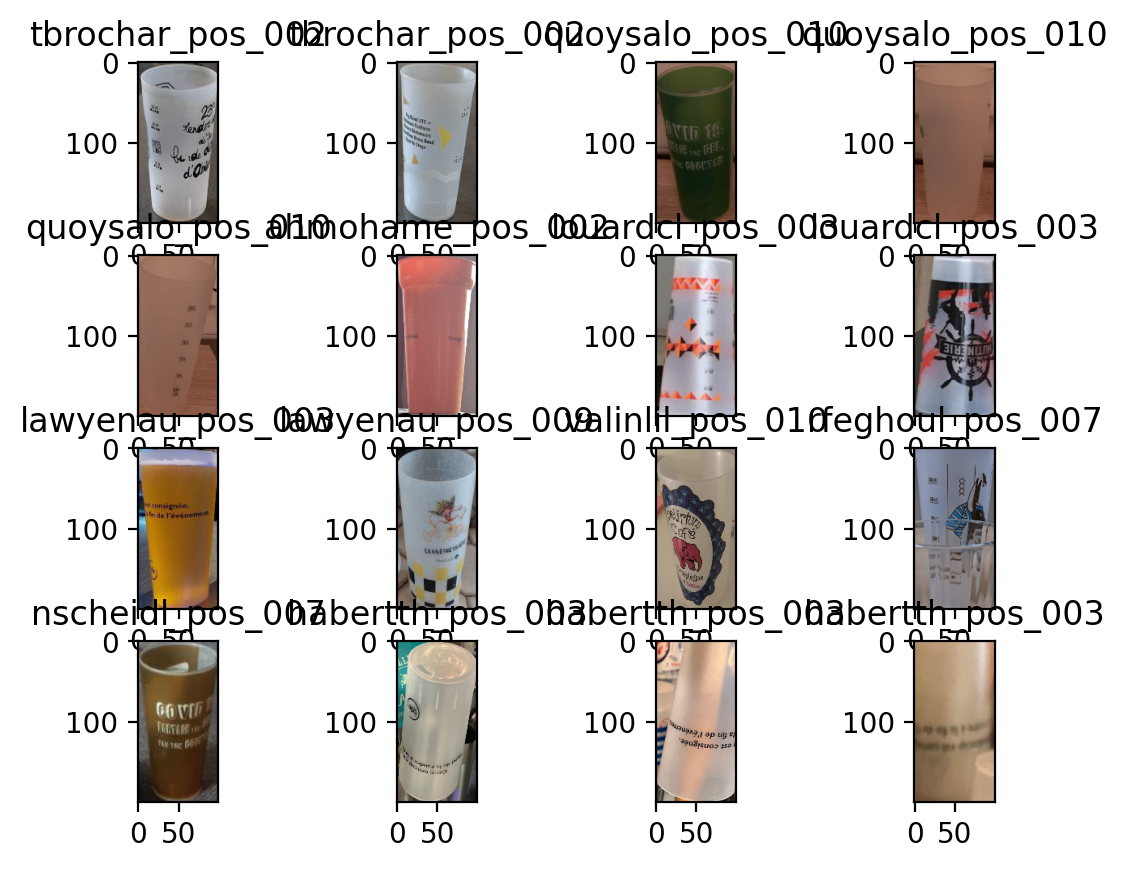

In [5]:
# show 8 images
fig, axs = plt.subplots(4, 4)
gen = get_pos_images()
for i, ax in enumerate(axs.flat):
    info, img = next(gen)
    ax.imshow(img, cmap='gray')
    ax.set_title(info[0])

In [6]:
# count training images
len(list(get_pos_images()))

439

In [7]:
save_pos_images()
#augment_pos_images(num_images=2)
generate_negative_images(1000)

/tmp/ipykernel_168989/2155737426.py:98: UserWarning: data/negative_images/0014.jpg is a low contrast image
  io.imsave(filepath, util.img_as_ubyte(patch))
/tmp/ipykernel_168989/2155737426.py:98: UserWarning: data/negative_images/0015.jpg is a low contrast image
  io.imsave(filepath, util.img_as_ubyte(patch))
/tmp/ipykernel_168989/2155737426.py:98: UserWarning: data/negative_images/0016.jpg is a low contrast image
  io.imsave(filepath, util.img_as_ubyte(patch))
/tmp/ipykernel_168989/2155737426.py:98: UserWarning: data/negative_images/0030.jpg is a low contrast image
  io.imsave(filepath, util.img_as_ubyte(patch))
/tmp/ipykernel_168989/2155737426.py:98: UserWarning: data/negative_images/0031.jpg is a low contrast image
  io.imsave(filepath, util.img_as_ubyte(patch))
/tmp/ipykernel_168989/2155737426.py:98: UserWarning: data/negative_images/0049.jpg is a low contrast image
  io.imsave(filepath, util.img_as_ubyte(patch))
/tmp/ipykernel_168989/2155737426.py:98: UserWarning: data/negative_ima

In [8]:
train_svm()

Validation accuracy: 0.83


SVC()

In [19]:
clf = joblib.load('data/svm_model.joblib')

0
1
2
3


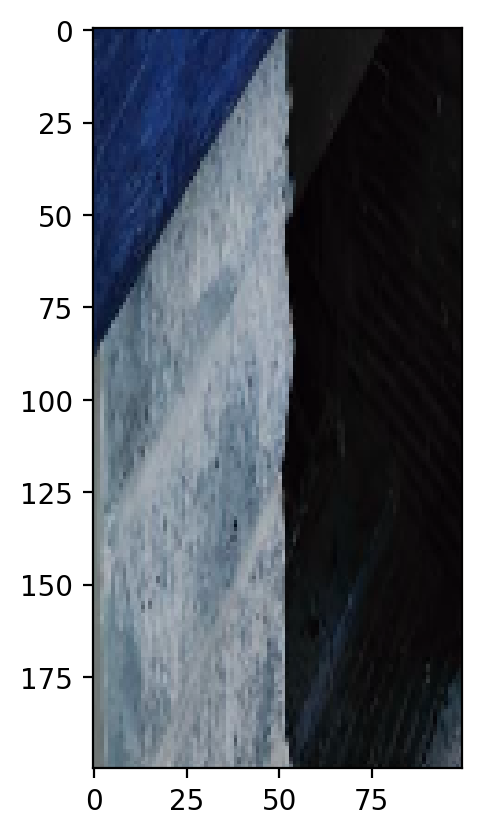

In [23]:
test_model(clf)

In [14]:
train_rf()

Validation accuracy: 0.84


RandomForestClassifier(random_state=42)

In [15]:
clf = joblib.load('data/svm_model.joblib')
test_rf(clf)

KeyboardInterrupt: 